# Data extraction, transformation, and loading into a JSON file
This is part of the project described in <https://github.com/amchagas/OSH_papers_DB>, check the project readme for more details.

This notebook loads data sources and merges them in a single compressed JSON file.

In [95]:
import os
import re
import numpy as np
import pandas as pd
import rispy
import matplotlib.pyplot as plt
from pathlib import Path
from project_definitions import baseDir, dataSourceDir, dataOutDir, figDir, articleDataFile
from project_definitions import store_data, load_data
from pprint import pprint
import html
from jellyfish import damerau_levenshtein_distance as edit_distance

## Sources

In [2]:
scieloSource = {
    'paths': [dataSourceDir / x for x in ("scielo.ris",)],
    'rispy_args': {},
    'col_rename': {},
    'transforms': [],
}
scopusSource = {
    'paths': [dataSourceDir / x for x in ("scopus.ris",)],
    'rispy_args': {},
    'col_rename': {},
    'transforms': [],
}
wosSource = {
    'paths': [dataSourceDir / x for x in ("wos1-500.ciw", "wos501-973.ciw")],
    'rispy_args': {'implementation': 'wok'},
    'col_rename': {'publication_year': 'year', 'document_title': 'title'},
    'transforms': [],
}

In [3]:
def load_source(dataSource):
    dfs = []
    for path in dataSource['paths']:
        with path.open() as f:
            df = pd.DataFrame(rispy.load(f, **dataSource['rispy_args']))
        df['__source'] = [[path.name] for _ in range(len(df))]
        dfs.append(df)
    cdf = pd.concat(dfs, join='outer', ignore_index=True)
    cdf = cdf.rename(columns=dataSource['col_rename'])
    for trans in dataSource['transforms']:
        cdf = cdf.transform(trans)
    return cdf.sort_index(axis=1)

In [4]:
scieloData = load_source(scieloSource)

In [5]:
scopusData = load_source(scopusSource)

In [6]:
wosData = load_source(wosSource)

In [7]:
allDataList = [scieloData, scopusData, wosData]

In [8]:
allData = pd.concat(allDataList, join='outer', ignore_index=True)

In [16]:
allData.describe()

,__source,abstract,alternate_title1,authors,database_provider,date,doi,end_page,file_attachments1,id,...,research_areas,researcher_id,source_abbreviation_29c,special_issue,supplement,total_times_cited_count,usage_count_180,usage_count_2013,wos_categories,wos_core_collection_cited_count
count,2475,2414,1499,2438,20,20,1880,991,19,20,...,972,455,752,38,5,973,973,973,972,973
unique,4,2390,927,2344,1,19,1330,645,19,20,...,217,407,440,2,3,66,14,78,349,65
top,[scopus.ris],The reasons for the inferior performance of ma...,HardwareX,"[Pearce, J.M.]",http://www.scielo.org/,2017-09,10.1590/S0100-40422013000800023,6,http://scielo.sld.cu/pdf/rie/v35n3/rie04314.pdf,S0012-73532016000100025-col,...,Engineering,"Pearce, J.M/C-9240-2013; Pearce, Joshua M/D-20...",SENSORS-BASEL,SI,1,0,0,0,"Engineering, Electrical & Electronic",0
freq,1482,3,46,12,20,2,3,14,1,1,...,116,13,40,37,3,378,735,263,46,379


In [17]:
def merge_series_keep_longest(sx):
    if sx.isna().all():
        return np.nan
    if sx.name == '__source':
        return sx.sum()
    return sx[sx.map(len, na_action='ignore').idxmax()]

def merge_records_keep_longest(dfx):
    return dfx.agg(merge_series_keep_longest)

In [72]:
# Merge data with same DOI
article_data = allData.loc[allData["type_of_reference"].eq('JOUR') | allData["publication_type"].eq('J')]
article_doi = article_data.groupby(article_data['doi'].values).agg(merge_records_keep_longest)
article_nodoi = article_data[~article_data.doi.isin(article_doi.index)]
article_data = pd.concat([article_doi, article_nodoi], ignore_index=True)

In [73]:
class Match:
    """
    Returns the same index as the first previously indexed value whose edit_distance is <= threshold,
    or a new index if none is found.
    """
    def __init__(self, df, threshold=0):
        self.df = df
        assert not df['title'].hasnans
        self.titles = self.get_clean_titles()
        self.threshold = threshold
        self.match_index = {}
    def get_clean_titles(self):
        return (
            self.df['title']
            .str.lower()
            .str.replace(r'[^\s\w]', ' ', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )
    def match(self, x):
        x = self.titles.loc[x]
        if x in self.match_index:
            return self.match_index[x]
        if self.threshold > 0:
            for m, idx in self.match_index.items():
                if edit_distance(x, m) <= self.threshold:
                    self.match_index[x] = idx
                    return self.match_index[x]
        self.match_index[x] = len(self.match_index)
        return self.match_index[x]

In [74]:
articles_g = article_data.groupby(Match(article_data, 5).match)

In [75]:
aa = articles_g.agg(list)[articles_g.size()>=2]

In [76]:
# Test alternatives matchers
# articles_gx = article_data.groupby(Match(article_data, 15).match)
# bb = articles_gx.agg(list)[articles_gx.size()>=2]
# set(Match(aa.explode('title')).get_clean_titles()).difference(Match(bb.explode('title')).get_clean_titles())
# set(Match(bb.explode('title')).get_clean_titles()).difference(Match(aa.explode('title')).get_clean_titles())

In [77]:
# Check match for years and authors (impl: first author last name)
assert aa['year'].map(lambda x: len(set(x)) < 2).all()
aa['authors'].map(
    lambda x: set(
        tuple(z.split(',')[0].split(' ')[-1] for z in y) # last name of each author
        for y in x
        if not ( isinstance(y, np.float) and pd.isna(y) ) # skip NANs
    )
).map(
    lambda x: sum(
        edit_distance(y, z) # sum the edit distances
        for x in list(zip(*x))[:1] # first authors
        for i, y in enumerate(x) for z in x[i+1:] # distinct pairs
    )
).max() < 2

True

In [78]:
article_data.describe()

,__source,abstract,alternate_title1,authors,database_provider,date,doi,end_page,file_attachments1,id,...,research_areas,researcher_id,source_abbreviation_29c,special_issue,supplement,total_times_cited_count,usage_count_180,usage_count_2013,wos_categories,wos_core_collection_cited_count
count,726,686,642,721,20,20,628,438,19,20,...,483,269,483,38,5,483,483,483,483,483
unique,10,683,369,697,1,19,628,342,19,20,...,134,241,287,2,3,60,14,77,183,61
top,"[scopus.ris, wos1-500.ciw]",The reasons for the inferior performance of ma...,HardwareX,"[Pearce, J.M.]",http://www.scielo.org/,2017-09,10.24084/repqj18.420,66,http://scielo.sld.cu/pdf/rie/v35n3/rie04314.pdf,S0012-73532016000100025-col,...,Engineering,"Pearce, J.M/C-9240-2013; Pearce, Joshua M/D-20...",SENSORS-BASEL,SI,1,0,0,0,"Chemistry, Analytical; Engineering, Electrical...",0
freq,246,3,46,10,20,2,1,6,1,1,...,47,13,40,37,3,127,288,49,40,127


In [91]:
article_data = articles_g.agg(merge_records_keep_longest)

In [92]:
article_data

,__source,abstract,alternate_title1,authors,database_provider,date,doi,end_page,file_attachments1,id,...,research_areas,researcher_id,source_abbreviation_29c,special_issue,supplement,total_times_cited_count,usage_count_180,usage_count_2013,wos_categories,wos_core_collection_cited_count
0,[wos501-973.ciw],"Ruairi Glynn, lecturer on interactive architec...",NaN,"[Glynn, R]",NaN,NaN,10.1002/ad.1707,NaN,NaN,NaN,...,Architecture,NaN,ARCHIT DESIGN,SI,NaN,1,0,14,Architecture,1
1,"[scopus.ris, wos1-500.ciw]",This paper presents the fusion of project-base...,Comput Appl Eng Educ,"[Jawaid, I., Javed, M.Y., Jaffery, M.H., Akram...",NaN,NaN,10.1002/cae.22184,192,NaN,NaN,...,Computer Science; Education & Educational Rese...,"Javed, Muhammad Yaqoob/AAJ-9473-2020; Javed, M...",COMPUT APPL ENG EDUC,NaN,NaN,5,4,29,"Computer Science, Interdisciplinary Applicatio...",5
2,"[scopus.ris, wos501-973.ciw]",We describe a completely randomizable flow-thr...,Ecology and Evolution,"[Duarte, G., Calderon, E.N., Pereira, C.M., Ma...",NaN,NaN,10.1002/ece3.1670,4566,NaN,NaN,...,Environmental Sciences & Ecology; Evolutionary...,"Duarte, Gustavo/AAM-2574-2020; Santos, Henriqu...",ECOL EVOL,NaN,NaN,20,0,72,Ecology; Evolutionary Biology,20
3,"[scopus.ris, wos501-973.ciw]",Understanding basic concepts of electronics an...,Electrophoresis,"[da Costa, E.T., Mora, M.F., Willis, P.A., do ...",NaN,NaN,10.1002/elps.201400128,2377,NaN,NaN,...,Biochemistry & Molecular Biology; Chemistry,"da Costa, Eric/D-5387-2012; Mora, Maria Fernan...",ELECTROPHORESIS,SI,NaN,29,1,94,"Biochemical Research Methods; Chemistry, Analy...",29
4,"[scopus.ris, wos1-500.ciw]",Open source paradigm is becoming widely accept...,Electrophoresis,"[Kubáň, P., Foret, F., Erny, G.]",NaN,NaN,10.1002/elps.201800304,78,NaN,NaN,...,Biochemistry & Molecular Biology; Chemistry,"Foret, Frantisek/D-9495-2012; Erny, Guillaume/...",ELECTROPHORESIS,SI,NaN,7,2,44,"Biochemical Research Methods; Chemistry, Analy...",7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,[wos501-973.ciw],The OpenWSN project is an open-source implemen...,NaN,"[Watteyne, T, Vilajosana, X, Tuset, P]",NaN,NaN,NaN,NaN,NaN,NaN,...,Computer Science,NaN,ERCIM NEWS,NaN,NaN,0,0,4,"Computer Science, Interdisciplinary Applications",0
702,[wos501-973.ciw],In recent times innovation has become the most...,NaN,"[Oviedo, SE, Diaz, D, Otazu, AM, Ibanez, F]",NaN,NaN,NaN,NaN,NaN,NaN,...,Education & Educational Research,"de Mendoza, Francisco Ruiz/ABG-4159-2020",CAMPUS VIRTUALES,NaN,NaN,0,0,8,Education & Educational Research,0
703,[wos501-973.ciw],One possible solution to small-scale automatio...,NaN,"[Murillo-Soto, LD]",NaN,NaN,NaN,NaN,NaN,NaN,...,Science & Technology - Other Topics,NaN,TECNOL MARCHA,NaN,NaN,0,0,3,Multidisciplinary Sciences,0
704,[wos501-973.ciw],NaN,NaN,"[Paulson, LD]",NaN,NaN,NaN,NaN,NaN,NaN,...,Computer Science,NaN,COMPUTER,NaN,NaN,4,0,6,"Computer Science, Hardware & Architecture; Com...",4


In [93]:
store_data(article_data, articleDataFile)

In [94]:
assert article_data.equals(load_data(articleDataFile))

## CSV sources

In [ ]:
plosData = pd.read_csv('https://raw.githubusercontent.com/amchagas/open-source-toolkit/main/plos-items.csv')

In [ ]:
sel_article = plosData["Content Type (URL items only - Research Article, Web Article, Commentary, Video, Poster)"].eq("Research Article")
sel_hardware = plosData["Hardware or software"].eq("hardware")
plosData = plosData.loc[sel_article & sel_hardware]
assert not plosData["URI (DOI or URL)"].isna().any()
plosData['Title (URL items only)'] = plosData['Title (URL items only)'].str.strip()
plosData

In [ ]:
plos2bibtex = {
    "URI (DOI or URL)": "doi",
    "": "",
}

In [ ]:
sel_new_doi = ~plosData["URI (DOI or URL)"].isin(allData.doi.values)
sel_new_doi.sum()

In [ ]:
sel_new_title = ~plosData["Title (URL items only)"].isin(allData.title.values)
sel_new_title.sum()

In [ ]:
# Same titles, different DOIs
x = plosData[["URI (DOI or URL)", "Title (URL items only)"]].loc[sel_new_doi & ~sel_new_title]
x['doi'] = [
    allData["doi"].loc[
        allData['title'].eq(y)
    ].squeeze()
    for y in x["Title (URL items only)"]
]
x

In [ ]:
# Same DOI, different Titles
pprint(plosData["Title (URL items only)"].loc[~sel_new_doi & sel_new_title])
print()
pprint(allData["title"].loc[
    allData["doi"].eq('10.1371/journal.pone.0023783')
])

# All done, now just mess around

In [84]:
data = nad

In [85]:
print(data.shape)
print(data.columns)

(706, 87)
Index(['__source', 'abstract', 'alternate_title1', 'authors',
       'database_provider', 'date', 'doi', 'end_page', 'file_attachments1',
       'id', 'issn', 'journal_name', 'keywords', 'language',
       'name_of_database', 'number', 'start_page', 'title', 'translated_title',
       'type_of_reference', 'url', 'volume', 'year', 'author_address',
       'custom2', 'custom3', 'custom7', 'notes', 'place_published',
       'publisher', 'secondary_authors', 'secondary_title', 'short_title',
       'type_of_work', 'accession_number', 'article_number',
       'author_full_name', 'author_keywords', 'beginning_page', 'book_authors',
       'book_authors_full_name', 'book_doi', 'book_group_authors',
       'book_series_title', 'cited_reference_count', 'conference_date',
       'conference_host', 'conference_location', 'conference_sponsors',
       'conference_title', 'date_generated', 'document_delivery_number',
       'document_type', 'early_access_date', 'editors', 'eissn',
       

In [86]:
print(article_data.shape)

(726, 87)


In [87]:
dup_title = article_data.duplicated('title', keep=False)
dup_doi = article_data.duplicated('doi', keep=False)
nan_doi = article_data['doi'].isna()
print(
    dup_title.sum(),
    dup_doi.sum(),
    nan_doi.sum(),
    (dup_title & dup_doi).sum(),
    (dup_title & ~dup_doi).sum(),
)

19 98 98 10 9


In [88]:
article_data.issn.str.replace('[^\d]', '', regex=True).value_counts()

24680672    46
14248220    41
21693536    20
19326203    12
15480992     9
            ..
19422660     1
13019724     1
20457758     1
13504177     1
02533219     1
Name: issn, Length: 410, dtype: int64

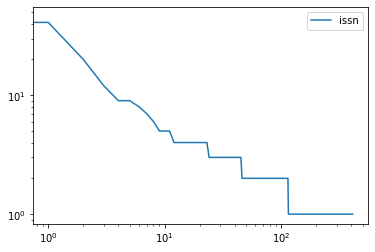

In [89]:
article_data.issn.str.replace('[^\d]', '', regex=True).value_counts().reset_index().plot(loglog=True)

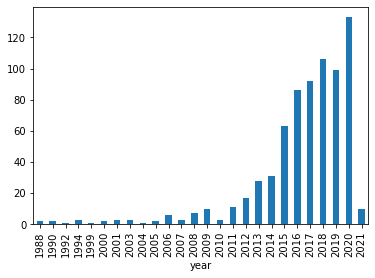

In [90]:
article_data.groupby('year').size().plot.bar()